In [1]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Parâmetros do sistema

In [ ]:
arquivo_raster = '/Users/marcelofernandes/My Drive/Arquivos/h_max_1.34953e+08_pacote100_090924.tif'
# Definindo o limite de altura
limite_minimo = 0 # em metros
limite_maximo = 35 # em metros

# Número de intervalos (bins) do histograma
numero_bins = 100

# Definir o limite de altura em metros (35 cm = 0.35 m)
limite_altura = 0.35

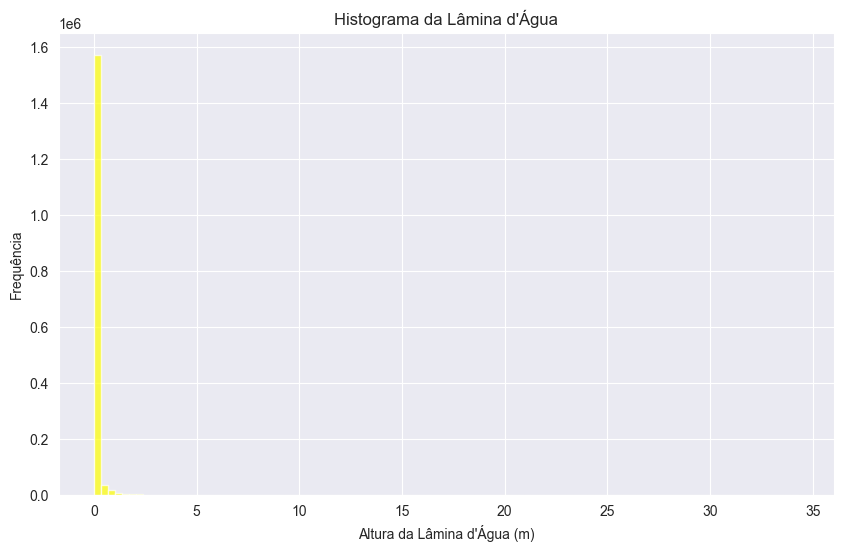

    Intervalo Inferior (m)  Intervalo Superior (m)  Frequência  Percentual (%)
0                 0.000000                0.343056     1571798         95.6496
1                 0.343056                0.686112       36206          2.2033
2                 0.686112                1.029168       15104          0.9191
3                 1.029168                1.372224        7175          0.4366
4                 1.372224                1.715280        3470          0.2112
..                     ...                     ...         ...             ...
95               32.590309               32.933365           0          0.0000
96               32.933365               33.276424           0          0.0000
97               33.276424               33.619480           0          0.0000
98               33.619480               33.962536           0          0.0000
99               33.962536               34.305592           2          0.0001

[100 rows x 4 columns]


In [3]:
# Abrindo o arquivo raster
with rasterio.open(arquivo_raster) as src:
    # Lendo a primeira banda do raster
    banda1 = src.read(1)

    # Obtendo o valor "NoData" do raster
    no_data_value = src.nodata
    
    # Criando uma máscara para filtrar os valores "NoData"
    if no_data_value is not None:
        mask = banda1 != no_data_value
        banda1 = banda1[mask]

    #Filtrando os valores acima de 30 cm e abaixo do limite máximo
    banda1_filtrada = banda1[(banda1 >= limite_minimo) & (banda1 <= limite_maximo)]

    # Criando o histograma
    plt.figure(figsize=(10, 6))
    plt.hist(banda1_filtrada.flatten(), bins=numero_bins, color='yellow', alpha=0.7)
    plt.title('Histograma da Lâmina d\'Água')
    plt.xlabel('Altura da Lâmina d\'Água (m)')
    plt.ylabel('Frequência')
    plt.grid(True)
    plt.show()
    
    # Gerando o histograma
    counts, bin_edges = np.histogram(banda1_filtrada, bins=numero_bins)
    
    # Calculando o percentual de cada intervalo em relação ao total de pixels filtrados
    total_pixels = counts.sum()
    porcentagens = np.round((counts / total_pixels) * 100,4) # Formatando para quatro casas decimais
    
    # Criando a tabela com os dados do histograma
    tabela_histograma = pd.DataFrame({
        'Intervalo Inferior (m)': bin_edges[:-1],
        'Intervalo Superior (m)': bin_edges[1:],
        'Frequência': counts,
        'Percentual (%)': porcentagens
    })

    # Exibindo a tabela
    print(tabela_histograma)

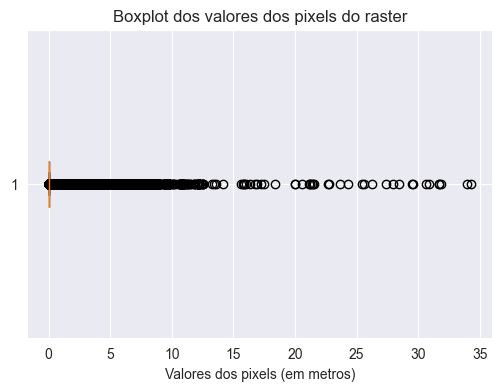

In [4]:
# Transformar o raster em uma lista de valores (1D) para criar o boxplot
pixel_values = banda1_filtrada.flatten()

# Criar o boxplot
plt.figure(figsize=(6, 4))
plt.boxplot(pixel_values, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title("Boxplot dos valores dos pixels do raster")
plt.xlabel("Valores dos pixels (em metros)")
plt.show()

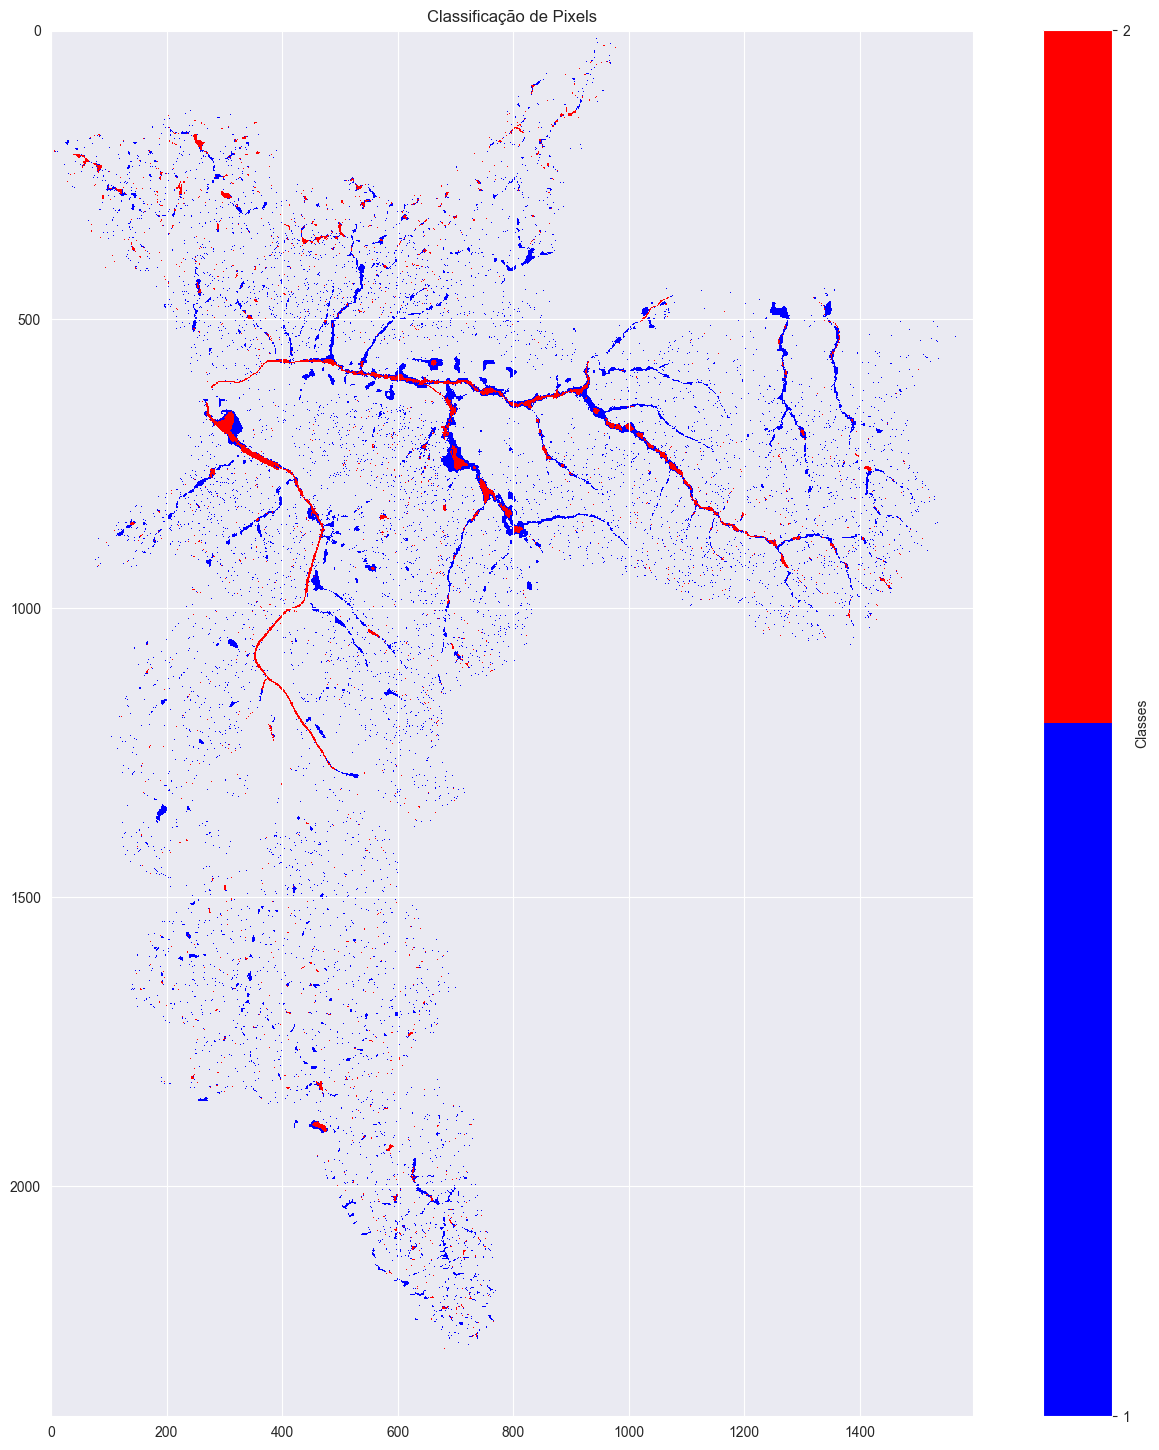

In [5]:
from matplotlib.colors import ListedColormap

# Abrindo o arquivo raster
with rasterio.open(arquivo_raster) as src:
    # Lendo a primeira banda do raster
    banda1 = src.read(1)

    # Obtendo o valor "NoData" do raster
    no_data_value = src.nodata
    
    # O erro TypeError: Invalid shape (1643290,) for image data ocorre porque, após aplicar a máscara banda1 = banda1[mask], o array resultante (banda1) se torna unidimensional (1D), mas a função plt.imshow() espera uma matriz 2D para visualizar corretamente uma imagem raster.
    
    # Criando uma máscara para filtrar os valores "NoData"
    if no_data_value is not None:
        mask = banda1 != no_data_value
    else:
        mask = np.ones_like(banda1, dtype=bool)  # Se não houver valor NoData, considerar todos os valores
    
    # Aplicar máscara para garantir que apenas valores válidos sejam considerados
    banda1_filtrada = np.where(mask, banda1, np.nan)  # Colocar NaN onde há NoData
    
   # Criar uma matriz de classificação
    classified_pixels = np.full(banda1_filtrada.shape, np.nan)  # Matriz vazia com NaN

    # Pixels entre 1m e 2m serão classificados como 1
    classified_pixels[(banda1_filtrada > 0.3) & (banda1_filtrada <= 1)] = 1

    # Pixels maiores que 2m serão classificados como 2
    classified_pixels[banda1_filtrada > 1] = 2

    # Criar um colormap personalizado
    cmap = ListedColormap(['blue', 'red'])  # Azul para classe 1, Vermelho para classe 2
    
    # Plotar o gráfico
    plt.figure(figsize=(18, 18))
    plt.imshow(classified_pixels, cmap=cmap, interpolation='none')
    plt.colorbar(ticks=[1, 2], label='Classes')  # Definir as classes no colorbar
    plt.title('Classificação de Pixels')
    
    # Exibir o gráfico
    plt.show()

In [6]:
# Filtragem dos outliers
# Referências:
# https://github.com/MeteHanC/Python-Median-Filter
# Explicação do ChatGPT:
# Filtro de Mediana (Altamente Recomendado)
#O filtro de mediana é particularmente útil para remover pequenos artefatos e ruídos sem alterar significativamente os valores importantes da imagem, como áreas de alagamento ou estruturas urbanas.
#Por que é útil?: A mediana preserva os detalhes das bordas e não é tão suscetível a valores extremos (outliers). Em áreas urbanas, onde os padrões de elevação e água podem variar drasticamente de pixel para pixel, a mediana pode suavizar inconsistências sem apagar dados críticos, como pequenos pontos de alagamento.

from scipy.ndimage import median_filter

# Aplica filtro de mediana com uma janela 3x3
banda1_filtrada_mediana = median_filter(banda1_filtrada, size=3)

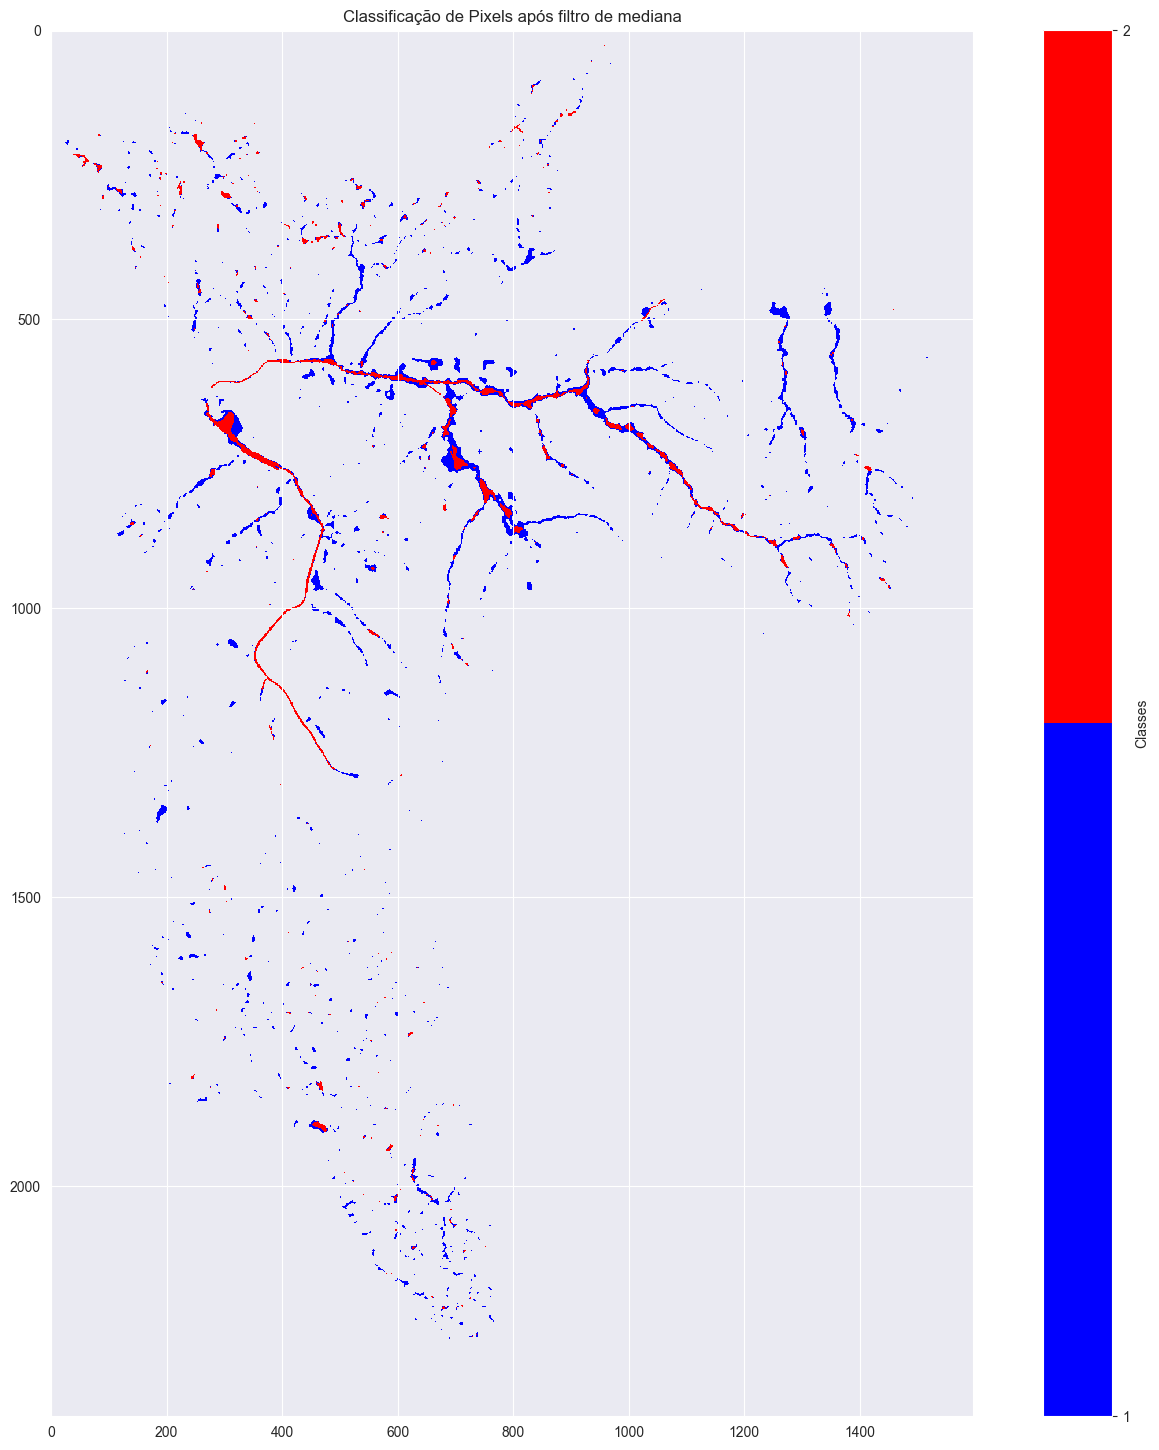

In [7]:
# Criar uma matriz de classificação
classified_pixels_mediana = np.full(banda1_filtrada_mediana.shape, np.nan)  # Matriz vazia com NaN

# Pixels entre 1m e 2m serão classificados como 1
classified_pixels_mediana[(banda1_filtrada_mediana > 0.3) & (banda1_filtrada_mediana <= 1)] = 1

# Pixels maiores que 2m serão classificados como 2
classified_pixels_mediana[banda1_filtrada_mediana > 1] = 2

# Criar um colormap personalizado
cmap = ListedColormap(['blue', 'red'])  # Azul para classe 1, Vermelho para classe 2
    
# Plotar o gráfico
plt.figure(figsize=(18, 18))
plt.imshow(classified_pixels_mediana, cmap=cmap, interpolation='none')
plt.colorbar(ticks=[1, 2], label='Classes')  # Definir as classes no colorbar
plt.title('Classificação de Pixels após filtro de mediana')
    
# Exibir o gráfico
plt.show()

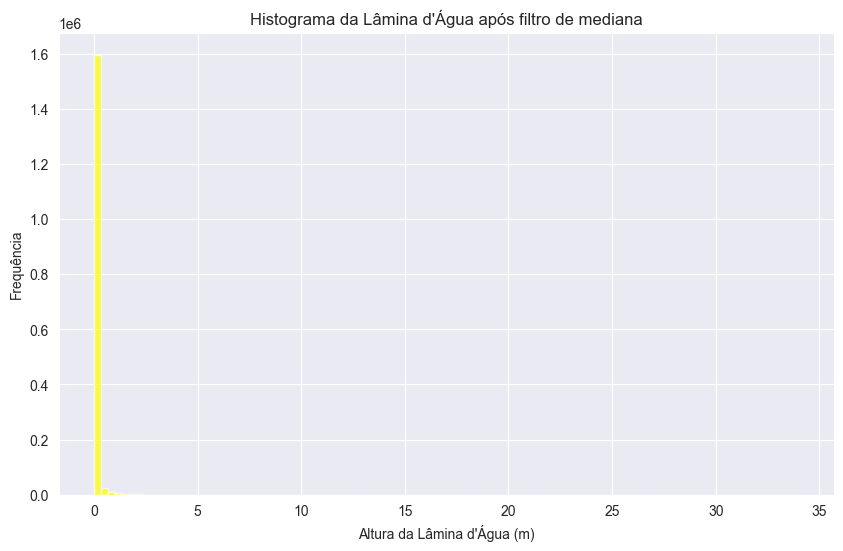

    Intervalo Inferior (m)  Intervalo Superior (m)  Frequência  Percentual (%)
0                 0.000000                0.339922     1596265         97.0314
1                 0.339922                0.679843       22715          1.3808
2                 0.679843                1.019765       10628          0.6460
3                 1.019765                1.359687        5351          0.3253
4                 1.359687                1.699608        2677          0.1627
..                     ...                     ...         ...             ...
95               32.292561               32.632481           0          0.0000
96               32.632481               32.972404           0          0.0000
97               32.972404               33.312325           0          0.0000
98               33.312325               33.652248           0          0.0000
99               33.652248               33.992168           2          0.0001

[100 rows x 4 columns]


In [8]:
# Criando o histograma
plt.figure(figsize=(10, 6))
plt.hist(banda1_filtrada_mediana.flatten(), bins=numero_bins, color='yellow', alpha=0.7)
plt.title('Histograma da Lâmina d\'Água após filtro de mediana')
plt.xlabel('Altura da Lâmina d\'Água (m)')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()
  
# Número de intervalos (bins) do histograma
numero_bins = 100

# Remover valores NaN
banda1_filtrada_mediana_2 = banda1_filtrada_mediana[~np.isnan(banda1_filtrada_mediana)]

# Gerando o histograma
counts, bin_edges = np.histogram(banda1_filtrada_mediana_2, bins=numero_bins)
    
# Calculando o percentual de cada intervalo em relação ao total de pixels filtrados
total_pixels = counts.sum()
porcentagens = np.round((counts / total_pixels) * 100,4) # Formatando para quatro casas decimais
    
# Criando a tabela com os dados do histograma
tabela_histograma = pd.DataFrame({
        'Intervalo Inferior (m)': bin_edges[:-1],
        'Intervalo Superior (m)': bin_edges[1:],
        'Frequência': counts,
        'Percentual (%)': porcentagens
    })

# Exibindo a tabela
print(tabela_histograma)

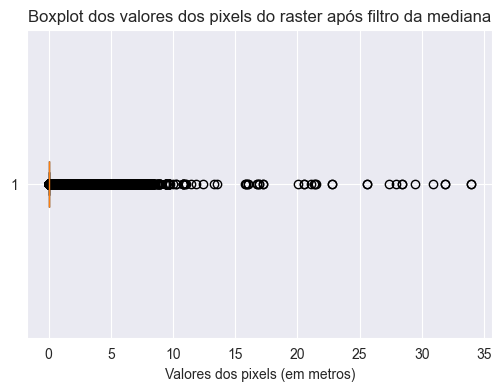

In [106]:
# Transformar o raster em uma lista de valores (1D) para criar o boxplot
pixel_values2 = banda1_filtrada_mediana_2.flatten()

# Criar o boxplot
plt.figure(figsize=(6, 4))
plt.boxplot(pixel_values2, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title("Boxplot dos valores dos pixels do raster após filtro da mediana")
plt.xlabel("Valores dos pixels (em metros)")
plt.show()

In [38]:
# Aplicar a limitação de valor máximo a 0.34
banda1_filtrada_mediana_3 = np.minimum(banda1_filtrada_mediana_2, 0.350)

In [37]:
banda1_filtrada_mediana.size

3831203

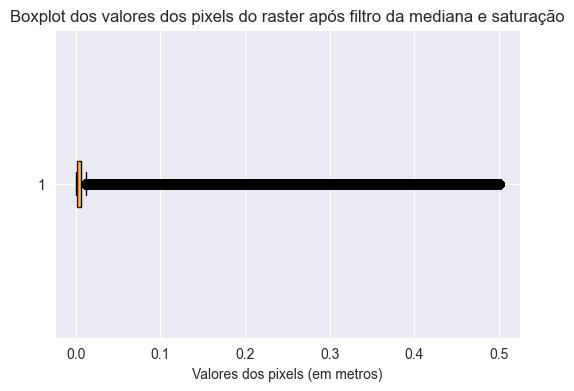

In [30]:
# Transformar o raster em uma lista de valores (1D) para criar o boxplot
pixel_values3 = banda1_filtrada_mediana_3.flatten()

# Criar o boxplot
plt.figure(figsize=(6, 4))
plt.boxplot(pixel_values3, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title("Boxplot dos valores dos pixels do raster após filtro da mediana e saturação")
plt.xlabel("Valores dos pixels (em metros)")
plt.show()

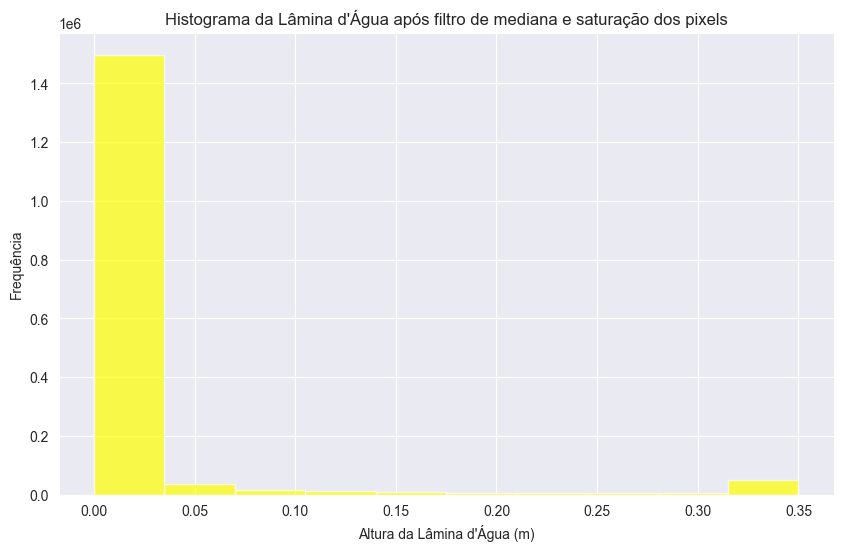

   Intervalo Inferior (m)  Intervalo Superior (m)  Frequência  Percentual (%)
0                   0.000                   0.035     1497183         91.0085
1                   0.035                   0.070       35365          2.1497
2                   0.070                   0.105       17521          1.0650
3                   0.105                   0.140       11603          0.7053
4                   0.140                   0.175        8966          0.5450
5                   0.175                   0.210        7278          0.4424
6                   0.210                   0.245        5759          0.3501
7                   0.245                   0.280        5244          0.3188
8                   0.280                   0.315        4446          0.2703
9                   0.315                   0.350       51737          3.1449


In [39]:
numero_bins = 10

# Transformar o raster em uma lista de valores (1D) para criar o boxplot
#pixel_values2 = raster_data.flatten()

# Criando o histograma
plt.figure(figsize=(10, 6))
plt.hist(banda1_filtrada_mediana_3.flatten(), bins=numero_bins, color='yellow', alpha=0.7)
plt.title('Histograma da Lâmina d\'Água após filtro de mediana e saturação dos pixels')
plt.xlabel('Altura da Lâmina d\'Água (m)')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

# Gerando o histograma
counts, bin_edges = np.histogram(banda1_filtrada_mediana_3, bins=numero_bins)
    
# Calculando o percentual de cada intervalo em relação ao total de pixels filtrados
total_pixels = counts.sum()
porcentagens = np.round((counts / total_pixels) * 100,4) # Formatando para quatro casas decimais
    
# Criando a tabela com os dados do histograma
tabela_histograma = pd.DataFrame({
        'Intervalo Inferior (m)': bin_edges[:-1],
        'Intervalo Superior (m)': bin_edges[1:],
        'Frequência': counts,
        'Percentual (%)': porcentagens
    })


# Exibindo a tabela
print(tabela_histograma)

In [ ]:
#TODO Para acima de 0,3m, classificar quais estão dentro de rio e quais pixels estão fora. Rodar antes de clipar o limite. 
# Tomar um raster do Geosampa e comparar com o raster do alagamento. MEdir as áreas.

### % dos pixels outliers

In [1]:
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.mask import mask
from shapely.geometry import mapping

TypeError: Invalid shape (1645102,) for image data

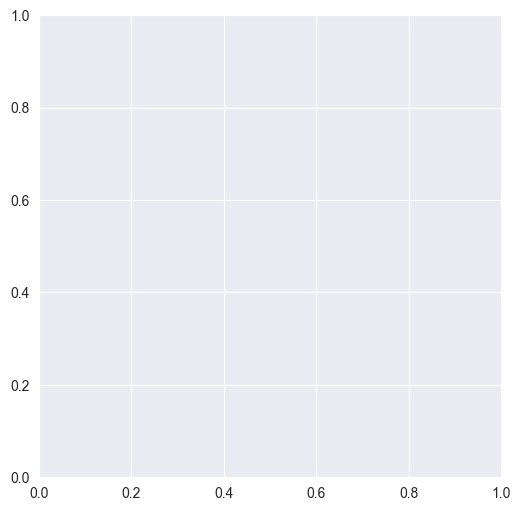

In [32]:
# 1. Carregar o raster de alagamento
with rasterio.open('raster_alagamento.tif') as raster:
    alagamento = raster.read(1)  # Lê a primeira banda do raster
    raster_profile = raster.profile  # Pega os metadados do raster
    raster_transform = raster.transform  # Transforma para coordenadas geográficas
    no_data_value = raster.nodata  # Pega o valor NoData se houver

# 2. Carregar o shapefile das bacias hidrográficas
bacias_hidro = gpd.read_file('bacias_hidrograficas.shp')

# 3. Mascara os pixels que estão sobre rios (dentro das geometrias do shapefile)
# Criar uma máscara a partir do shapefile das bacias hidrográficas
bacias_hidro_geom = [mapping(geom) for geom in bacias_hidro.geometry]

# Mascarar o raster de alagamento para encontrar pixels dentro dos rios
with rasterio.open('raster_alagamento.tif') as src:
    alagamento_mascarado, _ = mask(src, bacias_hidro_geom, invert=False)  # Mantém os rios
    alagamento_mascarado = alagamento_mascarado[0]  # Extraindo os dados do raster mascarado

# 4. Filtrar pixels de alagamento que excedem 35 cm de altura
alagamento_maior_35cm = np.where(alagamento > limite_altura, alagamento, np.nan)  # Pixels alagados > 35 cm

# 5. Identificar pixels fora dos rios (terrenos) comparando com a máscara de rios
# Mascara apenas os pixels de terreno (fora dos rios) que excedem a altura de 35 cm
terreno_mascarado = np.where(alagamento_maior_35cm != no_data_value, alagamento_maior_35cm, np.nan)  # Pixels válidos
terrenos_nao_rio = np.where(alagamento_mascarado == 0, terreno_mascarado, np.nan)  # Pixels que NÃO estão sobre rios

# 6. Calcular o percentual de pixels de terreno não rio (ou seja, terrenos) que excedem a altura de 35 cm
total_pixels_alagados = np.sum(np.isfinite(terreno_mascarado))  # Pixels alagados válidos (não NaN)
pixels_terreno = np.sum(np.isfinite(terrenos_nao_rio))  # Pixels sobre terrenos, fora dos rios

percentual_terreno = (pixels_terreno / total_pixels_alagados) * 100 if total_pixels_alagados > 0 else 0

# Exibir o resultado
print(f"Percentual de pixels alagados sobre terrenos (fora dos rios) com altura > 35 cm: {percentual_terreno:.2f}%")
